In [28]:
import sys
if '..' not in sys.path:
    sys.path.append('..')
    
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import networkx as nx
import copy
import scipy as sp
import math
import seaborn
import pickle
import warnings
import os

from lib.mobilitysim import MobilitySimulator
from lib.town_data import generate_population, generate_sites, compute_distances
from lib.town_maps import MapIllustrator

downsample_population = 100 # Downsample population numbers by a factor of 20
downsample_sites = 20 # Downsample sites by a factor of 10

# Set the population generation mode.
# 3 options available: custom | random | heuristic
population_by = 'custom'

population_path='lib/data/population/' # Directory containing FB population density files
sites_path='lib/data/queries/' # Directory containing OSM site files
bbox = (48.4900, 48.5485, 9.0224, 9.1061) # Coordinate bounding box

# Population per age group in Landkreis Tübingen
population_per_age_group = np.array([
    13416, # 0-4
    18324, # 5-14
    67389, # 15-34
    75011, # 35-59
    41441, # 60-79
    11750])# 80+

# Downsample population to Town of Tübingen (to be consistent with case data)
a = 90546 / (downsample_population * 227331)
population_per_age_group = np.round(
    population_per_age_group * a).astype('int').tolist()


# change essential population ratio here:
essential_to_total_ratio_list = [0.0]
summaries_ = []
for essential_to_total_ratio in essential_to_total_ratio_list:
    num_essential_workers = np.floor(sum(population_per_age_group)*essential_to_total_ratio).astype('int').tolist()


    essential_distribution = np.array([
        0,      # 0-4
        0,      # 5-14
        0.5,    # 15-34
        0.45,   # 34-59
        0.05,   # 60-79
        0])     # 80+

    num_essential_per_age_group = np.floor(num_essential_workers * essential_distribution).astype('int').tolist()
    essential_prop_per_age_group = np.divide((num_essential_per_age_group),(population_per_age_group))

    # This block sends queries to OpenStreetMap
    # Make sure you have a working internet connection
    # If an error occurs during execution, try executing again
    site_files=[]
    for root,dirs,files in os.walk(sites_path):
        for f in files:
            if f.endswith(".txt") and f != 'buildings.txt':
                site_files.append(sites_path+f)

    site_loc, site_type, site_dict, density_site_loc = generate_sites(bbox=bbox, query_files=site_files,
                                site_based_density_file='lib/data/queries/buildings.txt')


    density_files=[]
    for root,dirs,files in os.walk(population_path):
        for f in files:
            if f.endswith(".csv"):
                density_files.append(population_path+f)

    if population_by == 'custom':
    # generate population across tiles based on density input
        home_loc, people_age, home_tile, tile_loc, essential_workers, num_essential_workers = generate_population(density_files=density_files, bbox=bbox,
            population_per_age_group=population_per_age_group, tile_level=16, seed=42,
            essential_prop_per_age_group=essential_prop_per_age_group)
    
    elif population_by == 'random':
    # generate population across tiles uniformly at random
        home_loc, people_age, home_tile, tile_loc, essential_workers, num_essential_workers = generate_population(
            bbox=bbox, population_per_age_group=population_per_age_group,
            tile_level=16, seed=42,
            essential_prop_per_age_group=essential_prop_per_age_group)

    elif population_by == 'heuristic':
    # generate population across tiles proportional to buildings per tile
        home_loc, people_age, home_tile, tile_loc, essential_workers, num_essential_workers = generate_population(bbox=bbox, density_site_loc=density_site_loc,
                                population_per_age_group=population_per_age_group, tile_level=16, seed=42,
            essential_prop_per_age_group=essential_prop_per_age_group)
    
    essential_to_total_pop_ratio = num_essential_workers/sum(population_per_age_group)

    if downsample_sites > 1:
        np.random.seed(42)
    # downsample sites like populatoin
        idx = np.random.choice(len(site_loc), size=int(len(site_loc) / downsample_sites), 
                               replace=False, p=np.ones(len(site_loc)) / len(site_loc))

        new_site_loc, new_site_type = [], []
        site_loc, site_type = np.array(site_loc)[idx].tolist(), np.array(site_type)[idx].tolist()
    
    tile_site_dist = compute_distances(site_loc, tile_loc)

    dur_mean_per_type = [2, 1.5, 0.2, 2, 0.5]
    essential_dur_mean_per_type = [0.0 , 0.0 , 0.0 , 0.0, 8.0]
    variety_per_type = [1, 10, 5, 1, 2]

    # school, social, bus, office, supermarket
    mob_rate_per_age_per_type = [
        [5, 1, 0, 0, 0], # 0-4
        [5, 2, 1, 0, 0], # 5-14
        [2, 2, 1, 1, 1], # 15-34
        [0, 2, 1, 5, 1], # 35-59
        [0, 3, 2, 0, 1], # 60-79
        [0, 2, 1, 0, 1]] # 80+
    
    # convert to average visits per hour per week, to be compatible with simulator
    mob_rate_per_age_per_type = np.divide(np.array(mob_rate_per_age_per_type), (24.0 * 7))

    essential_mob_rate_per_type = [0 , 0 , 0 , 0, 7]
    essential_mob_rate_per_type = np.divide(np.array(essential_mob_rate_per_type), (24.0 * 7))

    # time horizon
    max_time = 17 * 24.0 # data availability
    delta  = 4.6438 # as set by distributions

    kwargs = dict(home_loc=home_loc, people_age=people_age, site_loc=site_loc,
        site_type=site_type, mob_rate_per_age_per_type=mob_rate_per_age_per_type,
        dur_mean_per_type=dur_mean_per_type, variety_per_type=variety_per_type, delta=delta,
        home_tile=home_tile, tile_site_dist=tile_site_dist,
        essential_workers=essential_workers,
        essential_mob_rate_per_type=essential_mob_rate_per_type,
        essential_dur_mean_per_type = essential_dur_mean_per_type) # emma

    with open(f'essential-prop{essential_to_total_ratio}_supermarket_settings_{downsample_population}_{downsample_sites}.pk', 'wb') as fp:
        pickle.dump(kwargs, fp)



    from lib.inference import *
    from lib.town_maps import MapIllustrator
    from lib.town_data import generate_population, generate_sites, compute_distances
    from lib.measures import (
        MeasureList,
        BetaMultiplierMeasure,
        BetaMultiplierMeasureByType,
        SocialDistancingForAllMeasure,
        SocialDistancingForKGroups,
        SocialDistancingByAgeMeasure,
        SocialDistancingForPositiveMeasure,
        ComplianceForAllMeasure,
        ComplianceForEssentialWorkers,
        Interval)
    from lib.data import collect_data_from_df
    from lib.plot import Plotter
    from lib.distributions import CovidDistributions
    from lib.parallel import *
    from bayes_opt import BayesianOptimization
    from lib.dynamics import DiseaseModel
    from lib.mobilitysim import MobilitySimulator
    import multiprocessing
    import re
    import matplotlib
    import warnings
    import pickle
    import seaborn
    import math
    import scipy as sp
    import copy
    import networkx as nx
    import numpy as np
    import pandas as pd
    import sys

    if '..' not in sys.path:
        sys.path.append('..')

    if __name__ == '__main__':

        mob_settings = 'essential-prop'+str(essential_to_total_ratio)+'_supermarket_settings_100_20.pk'
#         mob_setting  = 'essential-prop'+str(essential_to_total_ratio)+'_supermarket_settings_100_20.pk'
        
        random_repeats = 4

        # cpus_used = multiprocessing.cpu_count()
        cpus_used = 23

        c = 0  # seed
        FIGSIZE = (8, 4)

        # #### Import town settings

        tuned_p_stay_home = 0.2
        tuned_site_multipliers = [0.0, 0.0, 0.5, 0.5, 0.5]

        # See town-generator.ipynb for an example on how to create own settings
        with open(mob_settings, 'rb') as fp:
            obj = pickle.load(fp)
        mob = MobilitySimulator(**obj)
        np.random.seed(c)
        runstr = f'run{c}_'

        # General note for plotting: `errorevery` has to be set proportionally to `acc`, and best to keep `acc` as it is
        days_until_lockdown = 13  # March 10 - March 23
        days_after_lockdown = 20  # March 24 - April 12
        days_present = days_until_lockdown + days_after_lockdown + \
        2  # simulate 2 more days due to test lag
        days_future = 12 * 7  # projecting 12 weeks into the future

        case_downsample = 10
        new_cases_ = collect_data_from_df('LK Tübingen', 'new', until=days_present)
        resistant_cases_ = collect_data_from_df(
            'LK Tübingen', 'recovered', until=days_present)
        fatality_cases_ = collect_data_from_df(
            'LK Tübingen', 'fatality', until=days_present)


        # fatality rate per age group
        num_age_groups = fatality_cases_.shape[1]
        fatality_rates_by_age = (
            fatality_cases_[-1, :] / (new_cases_[-1, :] + fatality_cases_[-1, :] + resistant_cases_[-1, :]))

        print('Empirical fatality rates per age group:  ',
              fatality_rates_by_age.tolist())

        # Scale down cases based on number of people in simulation

        new_cases, resistant_cases, fatality_cases = (
            1/case_downsample * new_cases_,
            1/case_downsample * resistant_cases_,
            1/case_downsample * fatality_cases_)
        new_cases, resistant_cases, fatality_cases = np.ceil(
            new_cases), np.ceil(resistant_cases), np.ceil(fatality_cases)

        # Define initial seed count (based on infection counts on March 10)

        initial_seeds = {
            'expo': 1,
            'ipre': 1,
            'isym': 3,
            'iasy': 3,
        }
        present_seeds = {
            'expo': 3,
            'ipre': 1,
            'iasy': 0,
            'isym_notposi': 8,
            'isym_posi': 4,
            'resi_notposi': 78,
            'resi_posi': 110,
        }
        max_time_present = 24.0 * (days_present)
        max_time_future = 24.0 * (days_future)

        # #### Define standard testing parameters, same used for inference

        def standard_testing(max_time):
            standard_testing_params = {
                'testing_t_window': [0.0, max_time],  # in hours
                'testing_frequency': 24.0,     # in hours
            # in hours (actual and self-report delay)
                'test_reporting_lag': 48.0,
                'tests_per_batch': 10,       # assume 300 tests/day in LK Tübingen
                'test_smart_delta': 24.0 * 3,  # in hours
                'test_smart_duration': 24.0 * 7,  # in hours
                'test_smart_action': 'isolate',
                'test_smart_num_contacts': 10,
                'test_targets': 'isym',
                'test_queue_policy': 'fifo',
                'smart_tracing': None,
            }
            return standard_testing_params
        # #### Define distributions as estimated by literature
        #


        # instantiate correct distributions
        distributions = CovidDistributions(
            fatality_rates_by_age=fatality_rates_by_age)

        # #### Set epidemic parameters as inferred using Bayesian optimization

        # inferred parameters (see paper)
        inferred_params = {
            'betas': [1.1383] * 5,  # site infectivity by type
            'alpha': 0.3224,
            'mu': 0.2072
        }

        # Define function to run general type of experiment, fixing the above settings.

        def run(tparam, measure_list, t, local_seeds):

            # add standard measure of positives staying isolated
            measure_list += [
                SocialDistancingForPositiveMeasure(
                    t_window=Interval(0.0, t), p_stay_home=1.0)
            ]
            measure_list = MeasureList(measure_list)

            # run simulations
            summary = launch_parallel_simulations(
                mob_settings,
                distributions,
                random_repeats, cpus_used,
                inferred_params, local_seeds, tparam, measure_list,
                max_time=t,
                num_people=mob.num_people,
                num_sites=mob.num_sites,
                site_loc=mob.site_loc,
                home_loc=mob.home_loc, verbose=False)
            return summary


        def save_summary(summary, filename):
            with open('summaries/' + filename, 'wb') as fp:
                pickle.dump(summary, fp)

        def load_summary(filename):
            with open('summaries/' + filename, 'rb') as fp:
                summary = pickle.load(fp)
            return summary


    """
    ========================= END OF HEADER =========================

    """
    
    num_essen = 0
    num_non_essen = 0
    for i in range(mob.num_people):
        if mob.essential_workers[i]:
            num_essen += 1
        else:
            num_non_essen += 1
    
    essential_to_total_pop_ratio = num_essen/mob.num_people
    print('total population:',mob.num_people)
    print('essential:',num_essen,', non_essential:',num_non_essen,', propotion:',num_essen/mob.num_people)
    

        # ## Only simulate the future from here onwards
        #
        #

        # baseline (no measure for the future starting April 12)
        # future_baseline = run(standard_testing(max_time_future),
        #                       [], max_time_future, present_seeds)
        # save_summary(future_baseline, 'future_baseline_3.pk')

        # ### 4.3.5. Effects  of compliance on the efficacy of isolation for smart  tracing strategies

    testing_params_SD_6 = standard_testing(max_time_future)
    # time window considered for inspecting contacts
    testing_params_SD_6['test_smart_delta'] = 24.0 * 3
    testing_params_SD_6['test_smart_action'] = 'isolate'
    testing_params_SD_6['test_targets'] = 'isym'
    testing_params_SD_6['test_smart_num_contacts'] = 25
    isolation_days_SD_6 = 7  # how many days selected people have to stay in isolation
    duration_weeks_SD_6 = 12  # strategies tested for 12 weeks starting today

    summaries_SD_6 = dict()

    
    p_compliance_temp = [1.0]    
    p_compliance = [i * essential_to_total_pop_ratio for i in p_compliance_temp]
    p_compliance_essential = p_compliance_temp

    for policy in ['basic']:
        
        testing_params_SD_6['smart_tracing'] = policy

        for p in p_compliance:

            m = [SocialDistancingForSmartTracing(
                t_window=Interval(*testing_params_SD_6['testing_t_window']),
                p_stay_home=1.0,
                test_smart_duration=24.0 * isolation_days_SD_6),
                ComplianceForAllMeasure(
                t_window=Interval(*testing_params_SD_6['testing_t_window']),
                p_compliance=p)
            ]
            res = run(testing_params_SD_6, m, max_time_future, present_seeds)
            summaries_.append(res)

            print('all', p, ' done.')

        
#         for p_essential in p_compliance_essential:

#             m = [SocialDistancingForSmartTracing(
#                 t_window=Interval(*testing_params_SD_6['testing_t_window']),
#                 p_stay_home=1.0,
#                 test_smart_duration=24.0 * isolation_days_SD_6),
#                 ComplianceForEssentialWorkers(
#                 t_window=Interval(*testing_params_SD_6['testing_t_window']),
#                 p_compliance=p_essential)
#             ]
#             res = run(testing_params_SD_6, m, max_time_future, present_seeds)
#             summaries_.append(res)

#             print('essential', p_essential, ' done.')

                
    print('essential prop',essential_to_total_ratio, ' done.')
summaries_SD_6[policy] = summaries_
save_summary(summaries_SD_6, 'essential-prop'+str(essential_to_total_ratio_list)+'_comp'+str(p_essential)+'_repeats'+str(random_repeats)+'_'+mob_settings)
    


Data last updated at:  13.04.2020, 00:00 Uhr
Data last updated at:  13.04.2020, 00:00 Uhr
Data last updated at:  13.04.2020, 00:00 Uhr
Empirical fatality rates per age group:   [0.0, 0.0, 0.0, 0.001430615164520744, 0.00964630225080386, 0.11728395061728394]
total population: 909
essential: 0 , non_essential: 909 , propotion: 0.0
all 0.0  done.
essential prop 0.0  done.


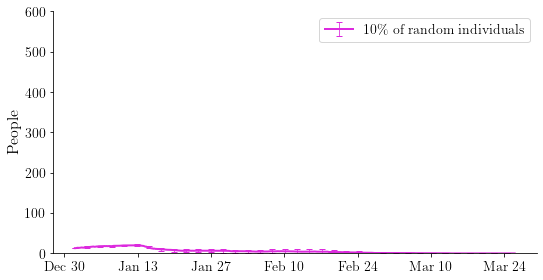

In [29]:
c = 0
runstr = f'run{c}_'

plotter = Plotter()
title = ['10\% of random individuals','100\% of supermarket workers','50\% of random individuals','100\% of supermarket workers']
for j, policy in enumerate(['basic']):
    summaries_ = summaries_SD_6[policy]
    plotter.compare_total_infections(
        summaries_, 
        titles=title, 
        figtitle=(f'Infections for compliance levels for ' + policy + ' tracing isolation'),
        filename=runstr + f'SD_6{j}', 
        figsize=FIGSIZE, acc=500, 
        ymax=600, errorevery=14)

In [25]:
print('essential-prop'+str(essential_to_total_ratio_list)+'_comp'+str(p_essential)+'_repeats'+str(random_repeats)+'_'+mob_settings)

essential-prop[0.1, 0.5]_comp1.0_repeats4_essential-prop0.5_supermarket_settings_100_20.pk
